<a href="https://colab.research.google.com/github/vparonov/AIPlayground/blob/main/MagicDarts_2021_03_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import h5py
import numpy as np
import time
import torch #pytorch
import torch.nn as nn
from torch.autograd import Variable 
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [3]:
def getFullPath(fileName):
  return 'drive/MyDrive/darts_data/' + fileName

In [4]:
class MagicDartsDataset(Dataset):
    """Magic Darts Dataset"""

    def __init__(self, h5_files, noise=True, transform=None):
        """
        Args:
            h5_file (string): Path to the h5 file.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.f = [] 
        
        for h5_file in h5_files:
          self.f.append(h5py.File(h5_file,'r'))

        dshape = self.f[0]['cur_time'].shape
        self.dataShape = dshape[:-1]
        self.timeDimSize = dshape[-1]

        nitems = 1 
        for s in self.dataShape:
          nitems *= s

        self.dataLen = nitems * len(h5_files)
        self.noise = noise 

        self.transform = transform
        
        if (noise == True):
          self.x_keys = ['cur_time', 
                        'x_hat_0', 'y_hat_0', 'z_hat_0',
                        'vx_cur_esti','vy_cur_esti','vz_cur_esti']
        else:
          self.x_keys =['cur_time', 'x_cur_clear', 'y_cur_clear', 'z_cur_clear',
                  'vx_cur_clear', 'vy_cur_clear', 'vz_cur_clear']



        self.y_keys = ['t_hit', 'x_results_real','y_results_real','z_results_real', 
                       'vx_cur_clear', 'vy_cur_clear', 'vz_cur_clear' ]

        x_preloaded = torch.zeros(self.dataLen, self.timeDimSize, len(self.x_keys)+1)
        y_preloaded = torch.empty(self.dataLen, 1, len(self.y_keys) + 1)

        for file_id, f in enumerate(self.f):
          for i, k in enumerate(self.x_keys):
            x_preloaded[file_id*nitems:(file_id*nitems + nitems), :, i] = torch.tensor(f[k][:].reshape(nitems, -1))

          for i, k in enumerate(self.y_keys):
            y_preloaded[file_id*nitems:(file_id*nitems + nitems), 0, i] = torch.tensor(f[k][:,:,:,-1].reshape(nitems))

        self.preloaded = torch.hstack((x_preloaded, y_preloaded))
        
    def getDataLen(self):
        return self.dataLen

    def indexToDims(self, idx):
      return idx 

    def __len__(self):
        return self.dataLen

    def __getitem__(self, idx):

        traj_ix = self.indexToDims(idx)

        x = self.preloaded[traj_ix,:-1,:]
        y = self.preloaded[traj_ix,-1,(1, 3)]

        sample = {'x':x, 'y': y, 'traj_ix': traj_ix}

        if self.transform:
            sample = self.transform(sample)
          
        return sample

In [5]:
class RandomPoints:
  def __init__(self, 
               placeholder_value, 
               max_time_points, 
               min_time_points = 0, 
               fixed_points = 0):
    
    self.placeholder_value = placeholder_value
    self.max_time_points = max_time_points
    self.min_time_points = min_time_points
    self.fixed_points = fixed_points

    self.all_ixes = np.arange(max_time_points)

    # keeps count of how many times 
    # specific number of points have been used
    self.traj_stats = np.zeros(max_time_points)

    # keeps count how many times 
    # specific time index has been used
    self.points_stats = np.zeros(max_time_points)

    # keep count how many times specific trajectory index
    # has been been used 
    self.traj_ixes = {}

  def __call__(self, sample):
    np.random.shuffle(self.all_ixes)


    if self.fixed_points > 0 :
      points = self.max_time_points  - self.fixed_points
    else:
      points = self.max_time_points - np.random.randint(self.min_time_points, self.max_time_points + 1)

    self.traj_stats[self.max_time_points - points - 1] += 1

    ixes = np.sort(self.all_ixes[:points])
    x = sample['x'].clone().detach()

    x_timepoints = x.size()[0]
    from_time_index = 0
    diff = x_timepoints
    if x_timepoints > self.max_time_points:
      diff = x_timepoints - self.max_time_points
      from_time_index = np.random.randint(0, diff + 1)

    #print("from_time_index =", from_time_index, "diff = ", diff)

    x = x[from_time_index:from_time_index + self.max_time_points,:]

    #print("x sise = ", x.size())
    #leave the cur_time value
    x[ixes, 1:-1] = self.placeholder_value#torch.tensor(float('nan'))
    x[ixes, -1] = 1

    self.points_stats[x[:, -1] == 0] += 1

    traj_ix = sample['traj_ix']
    if traj_ix in self.traj_ixes:
      self.traj_ixes[traj_ix] += 1
    else:
      self.traj_ixes[traj_ix] = 1

    return {'x': x, 'y': sample['y'], 'traj_ix':sample['traj_ix']}


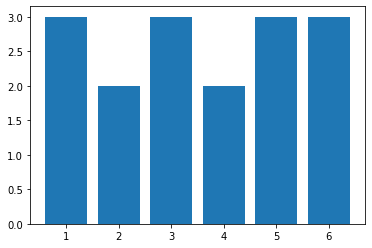

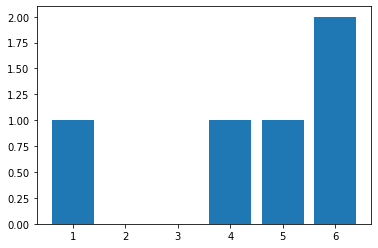

{0: 5}


In [6]:

ds = MagicDartsDataset([getFullPath('input_para_2021_03_10_file_1_cut_share.h5'), 
                                   getFullPath('input_para_2021_03_10_file_2_cut_share.h5'),
                                   getFullPath('input_para_2021_03_10_file_3_cut_share.h5'),
                                   getFullPath('input_para_2021_03_10_file_4_cut_share.h5')], noise=False, transform = RandomPoints(0, 6))

sample = ds[0]
sample = ds[0]
sample = ds[0]
sample = ds[0]
sample = ds[0]

plt.bar(np.arange(6) + 1, ds.transform.points_stats)
plt.show()
plt.bar(np.arange(6) + 1, ds.transform.traj_stats)
plt.show()

print(ds.transform.traj_ixes)

In [40]:
class LSTMTrial4(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, num_layers, dropout):
    super(LSTMTrial4, self).__init__()

    self.input_size = input_size 
    self.hidden_size = hidden_size
    self.output_size = output_size 
    self.num_layers = num_layers 
 
    self.fc_1 =  nn.Linear(input_size, 64) #fully connected 1
    self.fc =  nn.Linear(64, 64) #fully connected 1
  
    self.lstm = nn.LSTM(input_size=64, hidden_size=hidden_size,
                    num_layers=num_layers, 
                    batch_first=True, 
                    dropout=dropout) #lstm

    self.fc_2 =  nn.Linear(hidden_size, 128)
    self.fc_3 =  nn.Linear(128, hidden_size)
  
    self.fc_out =  nn.Linear(hidden_size, output_size) #fc output
  
    self.activation = nn.Tanh() ##nn.ReLU() 

  def forward(self,x):

      hidden = self.fc_1(x) #first Dense

      #hidden = self.relu(hidden) 

      #hidden = self.fc(hidden) #
       
      h_0 = Variable(torch.zeros(
            self.num_layers, hidden.size(0), self.hidden_size)).to('cuda') #hidden state
      
      c_0 = Variable(torch.zeros(
          self.num_layers, hidden.size(0), self.hidden_size)).to('cuda') #internal state
  
      # Propagate input through LSTM

      output, (hn, cn) = self.lstm(hidden, (h_0, c_0)) #lstm with input, hidden, and internal state
  
      h = hn[-1,:,:].view(-1, self.hidden_size)

      h = self.activation(h) 

      h = self.fc_2(h)
      h = self.activation(h) 

      h = self.fc_3(h)
      h = self.activation(h) 

     ## h = self.fc_4(h)
     ## h = self.relu(h) 

      out = self.fc_out(h)

      return out

In [7]:
ds = MagicDartsDataset([getFullPath('input_para_2021_03_10_file_1_cut_share.h5'), 
                                   getFullPath('input_para_2021_03_10_file_2_cut_share.h5'),
                                   getFullPath('input_para_2021_03_10_file_3_cut_share.h5'),
                                   getFullPath('input_para_2021_03_10_file_4_cut_share.h5')], noise=False, transform = RandomPoints(0, 52))

train_size = int(0.9 * len(ds))
test_size = len(ds) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(ds, [train_size, test_size])

print(len(train_dataset), len(test_dataset))

batch_size = 1000
train_dataloader = DataLoader(train_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=0)

21600 2400


In [33]:
f = open("drive/MyDrive/darts_data/test_traj_ixes_2021_03_20.txt", "w")

test_dataloader = DataLoader(test_dataset, batch_size=1,
                        shuffle=True, num_workers=0)
for batch, sample in enumerate(test_dataloader):
  traj_ix = sample['traj_ix']
  f.write("%d\n".format(traj_ix.item()))
f.close()

In [41]:
learning_rate = 0.001 

input_size = 8
hidden_size = 64
num_layers = 4

output_size = 2 
dropout  = 0.5

model = LSTMTrial4(input_size = input_size, 
                   hidden_size = hidden_size, 
                   output_size = output_size, 
                   num_layers = num_layers, 
                   dropout = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(device)

cuda


Epoch: 0, loss: 0.0036579800 test loss: 0.0447398201
Epoch: 1, loss: 0.0007155037 test loss: 0.0297576468
Epoch: 2, loss: 0.0006377037 test loss: 0.0278177205
Epoch: 3, loss: 0.0006224235 test loss: 0.0268765334
Epoch: 4, loss: 0.0005658052 test loss: 0.0221266113
Epoch: 5, loss: 0.0004594397 test loss: 0.0186166577
Epoch: 6, loss: 0.0004090058 test loss: 0.0170568582
Epoch: 7, loss: 0.0003769872 test loss: 0.0159385931
Epoch: 8, loss: 0.0003640689 test loss: 0.0154512282
Epoch: 9, loss: 0.0003498466 test loss: 0.0151791358
Epoch: 10, loss: 0.0003420402 test loss: 0.0145892482
Epoch: 11, loss: 0.0002856182 test loss: 0.0100165922
Epoch: 12, loss: 0.0001778787 test loss: 0.0065228688
Epoch: 13, loss: 0.0001265516 test loss: 0.0071914005
Epoch: 14, loss: 0.0001060854 test loss: 0.0057378882
Epoch: 15, loss: 0.0000900876 test loss: 0.0040089861
Epoch: 16, loss: 0.0000798110 test loss: 0.0034797944
Epoch: 17, loss: 0.0000865993 test loss: 0.0050195837
Epoch: 18, loss: 0.0000794732 test los

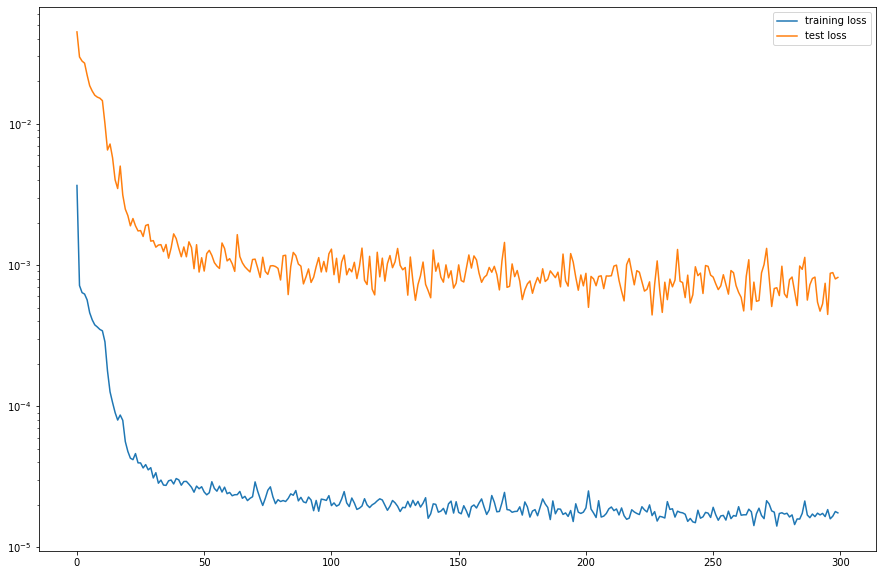

In [42]:
num_epochs = 300

test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset),
                        shuffle=True, num_workers=0)

#learning_rate = 0.0001
epoch_loss = []
epoch_test_loss = []

model.train()
for epoch in range(num_epochs):
  current_loss = 0 
  for batch, sample in enumerate(train_dataloader):
    #print(sample['x'].permute(.shape)
    #print("x=", sample['x'].size())
    outputs = model.forward(sample['x'].to(device)) #forward pass
    #print("outputs=", outputs)
    optimizer.zero_grad() #caluclate the gradient, manually setting to 0
    #print(outputs.shape)
    # obtain the loss function
    #loss = torch.sqrt(criterion(outputs, sample['y'].to(device)))
    loss = criterion(outputs, sample['y'].to(device))
    loss.backward() #calculates the loss of the loss function
    current_loss += loss.item()
    optimizer.step() #improve from loss, i.e backprop
    #print("loss: %1.5f" % (loss.item())) 
    if epoch % 20 == 0:
      torch.save(model.state_dict(), 'drive/MyDrive/darts_data/lstm4.pd')

  current_test_loss = 0 
  for batch, sample in enumerate(test_dataloader):
    with torch.no_grad():
      outputs = model.forward(sample['x'].to(device)) #forward pass  
      loss = criterion(outputs, sample['y'].to(device))
      current_test_loss += loss.item()

  epoch_test_loss.append(current_test_loss)

  epoch_loss.append(current_loss/batch_size)

  print("Epoch: %d, loss: %1.10f test loss: %1.10f" % (epoch, current_loss/batch_size, current_test_loss)) 

torch.save(model.state_dict(), 'drive/MyDrive/darts_data/lstm4.pd')
#plt.plot(epoch_loss)
plt.semilogy(epoch_loss, label="training loss")
plt.semilogy(epoch_test_loss, label="test loss")
plt.legend()
plt.show()

In [ ]:

plt.bar(np.arange(20) + 1, ds.transform.points_stats)
plt.show()
plt.bar(np.arange(20) + 1, ds.transform.traj_stats)
plt.show()

plt.bar(ds.transform.traj_ixes.keys(), ds.transform.traj_ixes.values())
plt.show()

In [ ]:
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset),
                        shuffle=True, num_workers=0)

eloss = []
model.eval()
for epoch in range(100):
  for batch, sample in enumerate(test_dataloader):
    with torch.no_grad():
      outputs = model.forward(sample['x'].to(device)) #forward pass  
      loss = criterion(outputs, sample['y'].to(device))
      eloss.append(loss.item()/batch_size)


plt.hist(eloss)
plt.show()

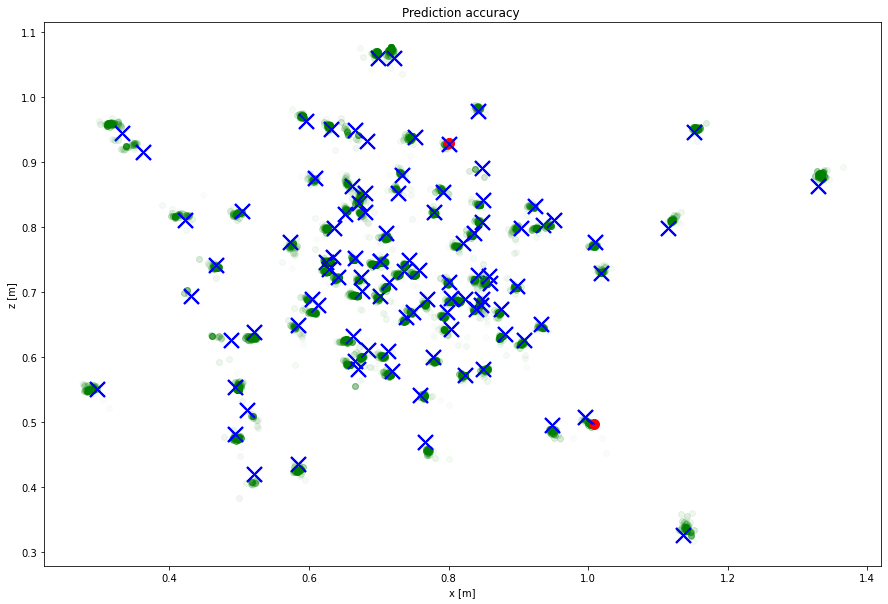

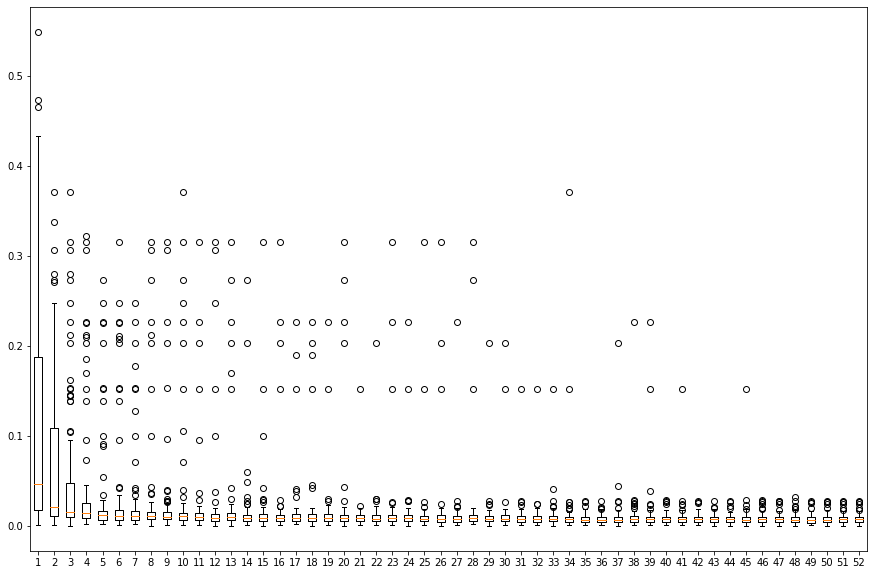

In [43]:
plot_predictions = True 
plt.rcParams["figure.figsize"] = (15,10)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = LSTMTrial4(input_size = 8, hidden_size = 64, output_size = 2, num_layers = 4, dropout = 0)
model.load_state_dict(torch.load(getFullPath('lstm4.pd'), map_location=torch.device('cpu')))
model = model.to(device)
model.eval()

criterion = torch.nn.MSELoss()

#2400
#datafile = [getFullPath('20210224094951_cut_share.h5')]
#datafile = [getFullPath('vangel_2021_03_04_01_edited_cut_share.h5')]
#datafile = [getFullPath('input_para_2021_03_10_file_1_cut_share.h5'), 
#             getFullPath('input_para_2021_03_10_file_2_cut_share.h5'), 
#             getFullPath('input_para_2021_03_10_file_3_cut_share.h5'), 
#             getFullPath('input_para_2021_03_10_file_4_cut_share.h5')]

ds = MagicDartsDataset(datafile, noise=False)

test_dataloader = DataLoader(test_dataset, batch_size=1,
                        shuffle=True, num_workers=0)

max_traj = 100
max_points = 52 
distances = np.zeros((max_traj, max_points))

model.eval()
ix = 0
has_point_plots = False

for sample_index, sample in enumerate(test_dataloader):
  if sample_index == max_traj:
    break
  with torch.no_grad():
    for i in range(0, max_points):

      cutter = RandomPoints(0, max_time_points=max_points, fixed_points=i+1)
      
      sample['x'] = sample['x'].squeeze()
      sample['y'] = sample['y'].squeeze()

      cut_sample = cutter(sample)

      x_full = cut_sample['x'].to(device).unsqueeze(0)
      y_full = cut_sample['y'].to(device).unsqueeze(0)

      outputs = model.forward(x_full)   
      #print(x_full, outputs)
      loss = criterion(outputs, y_full)
      
      npoints = int(max_points - x_full[0, :, 7].sum().item()) 

      #print(npoints)

      hp_x_hat = outputs[0,0].item()
      hp_z_hat = outputs[0,1].item()
      hp_x = y_full[0, 0].item()
      hp_z = y_full[0, 1].item()

      distance = np.sqrt((hp_x_hat - hp_x)**2 + (hp_z_hat - hp_z)**2)
      #print(distance)
      distances[sample_index, i] = distance

      if npoints > max_points/2 and distance > 0.06:
        has_point_plots = True 
        plt.plot([y_full[0,0], outputs[0, 0]], [y_full[0, 1], outputs[0, 1]], c='b') 
        plt.scatter(outputs[0, 0].item(), outputs[0, 1].item(),c='g') #, alpha = npoints/52)
        plt.scatter(y_full[0, 0].item(), y_full[0, 1].item(), c='b', marker='x', s=200)
        plt.annotate(f"{npoints}", (hp_x_hat, hp_z_hat))
      else:
        if plot_predictions :
          has_point_plots = True 
          if npoints == max_points-1:
            plt.scatter(outputs[0, 0].item(), outputs[0, 1].item(),c='r', s = 100)
            plt.plot([y_full[0,0], outputs[0, 0]], [y_full[0, 1], outputs[0, 1]], c='b') 
          else:
            plt.scatter(outputs[0, 0].item(), outputs[0, 1].item(),c='g', alpha = npoints/52)
          plt.scatter(y_full[0, 0].item(), y_full[0, 1].item(), c='b', marker='x', s=200)
          #
          #if npoints % 5 == 0:
          #  plt.annotate(f"{npoints}", (hp_x_hat, hp_z_hat))
    
distances = np.nan_to_num(distances, nan = 0)

if has_point_plots:
  plt.title(f'Prediction accuracy ')
  plt.xlabel('x [m]')
  plt.ylabel('z [m]')
  plt.show()

plt.boxplot(distances)
plt.show()

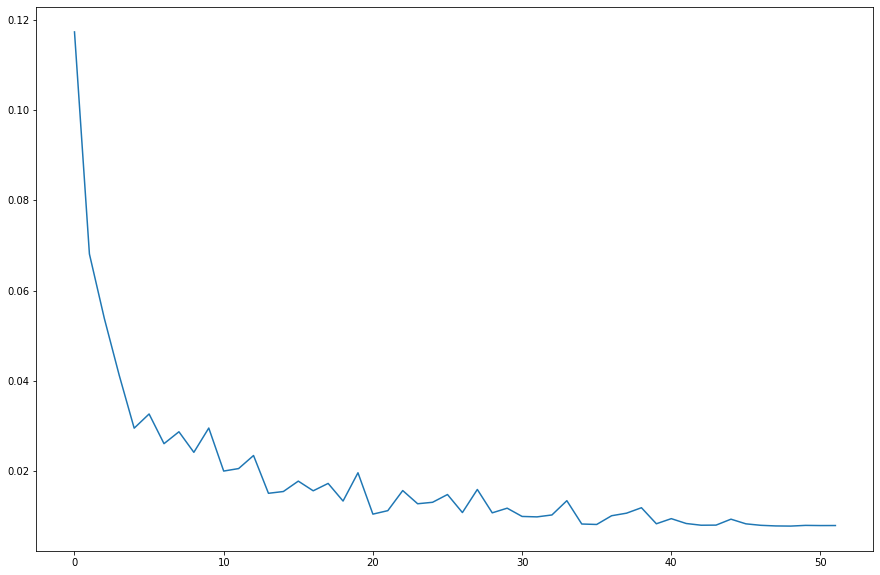

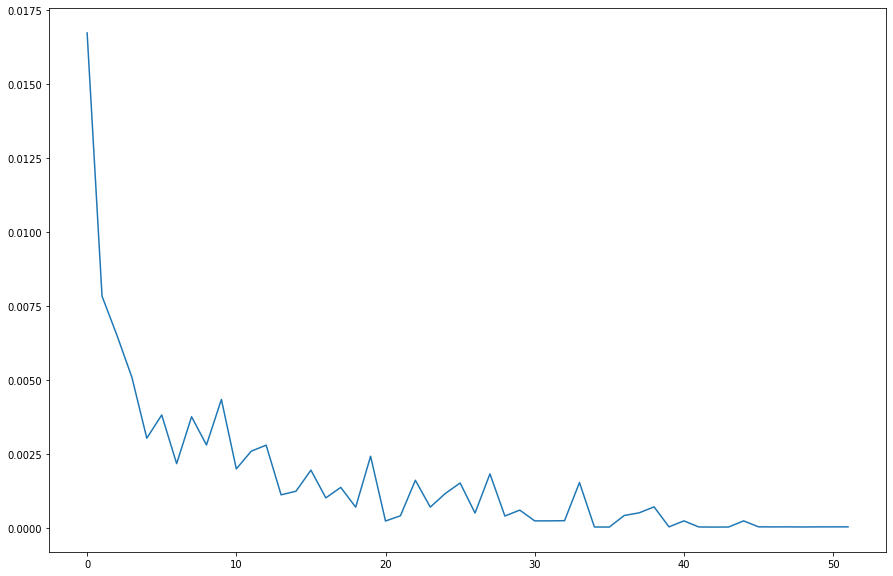

In [44]:
distances = np.nan_to_num(distances)
plt.plot(distances.mean(axis=0))
plt.show()
plt.plot(distances.var(axis=0))

In [57]:
print(distances[19,:].nan_to_num(0))

AttributeError: ignored